### Imports and config

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, recall_score, roc_curve, multilabel_confusion_matrix, confusion_matrix
import copy

#Metrics
from metrics import *
#Utils
from utils import *
#Properties
from utils import properties as p


#Model
import nn_model as nn

#Config
%config InlineBackend.figure_format='retina'
%load_ext jupyternotify

<IPython.core.display.Javascript object>

### Setup properties

In [2]:
p.update({
    
    #Age range
    'age_min' : 0,
    'age_max' : 39,
    
    #Number of data samples
    'data_samples' : 20000
    
})

### Read data

In [3]:
df = pd.read_csv('../dataset/data.csv')

### Prepare dataset

In [4]:
#Remove other ethnicities
del p['ETHNICITIES'][4]
df = df[df['ethnicity'] != 4]
#print_summary(df)

In [5]:
def age_filter(df, age_min, age_max):
    return (df['age'] >= age_min) & (df['age'] <= age_max)

def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == p['ETHNICITIES'][i]) & (df['gender'] == p['GENDERS'][j])

def ethnicity_age_filter(df, e, age_min, age_max):
    return (df['ethnicity'] == p['ETHNICITIES'][e]) & age_filter(df, age_min, age_max)

def ethnicity_gender_age_filter(df, i, j, age_min, age_max):
    return ethnicity_gender_filter(df, i, j) & age_filter(df, age_min, age_max)

In [6]:
#Prepare
df = df.loc[age_filter(df, p['age_min'], p['age_max'])]
df['ethnicity'] = df['ethnicity'].map(p['ETHNICITIES'])
df['gender'] = df['gender'].map(p['GENDERS'])

### Create balanced dataset

In [7]:
#Ethnicity gender age sample size
ethnicity_age_sample_size = round(p['data_samples'] / (round(p['age_range']() / p['age_bins']) * len(p['ETHNICITIES'])))

balanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_m, age_M)]\
        .sample(ethnicity_age_sample_size, random_state=p['seed'], replace=True)
    for e in range(len(p['ETHNICITIES']))
    #for j in range(len(GENDERS))
    for (age_m, age_M) in p['bins']()
])

### Create unbalanced dataset

In [8]:
def create_unbalanced_set(df, minority_proportion=0.05, majority_group=0):
    min_factor = minority_proportion # 5% of the population 
    maj_factor = 1 - min_factor

    #Size of minority group
    min_sample_size = round(p['data_samples'] * min_factor / len(p['bins']()) / (len(p['ETHNICITIES']) - 1))

    #Size of majority group
    maj_sample_size = round(p['data_samples'] * maj_factor / len(p['GENDERS']) / len(p['bins']()))

    maj_male = pd.concat([
        df.loc[ethnicity_gender_age_filter(df, majority_group, 0, age_min, age_max)]\
            .sample(maj_sample_size, random_state=p['seed'], replace=True)
        for (age_min, age_max) in p['bins']()
    ])

    maj_female = pd.concat([
        df.loc[ethnicity_gender_age_filter(df, majority_group, 1, age_min, age_max)]\
            .sample(maj_sample_size, random_state=p['seed'], replace=True)
        for (age_min, age_max) in p['bins']()
    ])

    unbalanced_df = pd.concat([
        df.loc[ethnicity_age_filter(df, e, age_min, age_max)]\
            .sample(min_sample_size, random_state=p['seed'], replace=True)
        for e in range(len(p['ETHNICITIES']))
        #for j in range(len(GENDERS))
        for (age_min, age_max) in p['bins']()
        if e != majority_group
    ] + [maj_female, maj_male])
    
    return unbalanced_df

## Predictive Model

### Model

In [9]:
# network (not federated)

def standard_nn():
    return nn.get_standard_nn(p['seed'])

### Evaluate predictive model

In [10]:
def evaluate_ethnicity(dataset, ethnicity, df_test, model):
    ethn_y, ethn_y_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model)
    score = f1_score(convert_output(ethn_y), convert_output(ethn_y_pred), average='macro')
    return score

def evaluate_ethnicity_accuracy(dataset, ethnicity, df_test, model):
    ethn_y, ethn_y_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model)
    score = get_accuracy(convert_output(ethn_y), convert_output(ethn_y_pred))
    return score

def evaluate_all_ethnicities(dataset, df_test, model):
    scores = [evaluate_ethnicity(dataset, e, df_test, model) for e in p['ETHNICITIES'].values()]
    return dict(zip(p['ETHNICITIES'].values(), scores))

def evaluate_all_ethnicity_accuracy(dataset, df_test, model):
    scores = [evaluate_ethnicity_accuracy(dataset, e, df_test, model) for e in p['ETHNICITIES'].values()]
    return dict(zip(p['ETHNICITIES'].values(), scores))

def get_ethnicity_predictions(dataset, df_test, ethnicity, model):
    idx_keys = dataset.index.intersection(df_test[df_test['ethnicity'] == ethnicity].index)
    ethn_df = dataset.loc[idx_keys]
    ethn_X = prepare_X(ethn_df)
    ethn_y = prepare_y(ethn_df)         #y_true 
    ethn_y_pred = model.predict(ethn_X) #y_pred 
    return ethn_y, ethn_y_pred

def ethnicity_equal_odd_difference(dataset, df_test, ethnicity, model, privileged_group, ethn_y_p, ethn_y_p_pred):
    
    if ethnicity == privileged_group:
        return 0
    
    ethn_y_u, ethn_y_u_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model) #unprivileged
    
    return np.mean(equal_odd_difference(
        one_hot_vect_to_class(convert_output(ethn_y_p)), 
        one_hot_vect_to_class(convert_output(ethn_y_p_pred)), 
        one_hot_vect_to_class(convert_output(ethn_y_u)), 
        one_hot_vect_to_class(convert_output(ethn_y_u_pred))
    ))

def ethnicity_equality_metric(
    dataset, 
    df_test, 
    ethnicity, 
    model, 
    privileged_group, 
    ethn_y_p, 
    ethn_y_p_pred, 
    metric_fun):
    if ethnicity == privileged_group:
        return 0
    
    ethn_y_u, ethn_y_u_pred = get_ethnicity_predictions(dataset, df_test, ethnicity, model) #unprivileged
    
    return np.nanmean(metric_fun(
        one_hot_vect_to_class(convert_output(ethn_y_p)), 
        one_hot_vect_to_class(convert_output(ethn_y_p_pred)), 
        one_hot_vect_to_class(convert_output(ethn_y_u)), 
        one_hot_vect_to_class(convert_output(ethn_y_u_pred))
    ))

def all_ethnicity_equal_difference(
    dataset, df_test, model, privileged_group, ethn_y_p, ethn_y_p_pred, metric_fn_list
):
    scores = [
        np.nanmean(np.abs([
            ethnicity_equality_metric(
                dataset, 
                df_test, 
                e, 
                model, 
                privileged_group, 
                ethn_y_p, 
                ethn_y_p_pred,
                metric_fn
            ) 
            for e in p['ETHNICITIES'].values()
        ])) for metric_fn in metric_fn_list
    ]
    metrics_list = ['Abs avg. ' + m.__name__.replace('_', ' ').capitalize() for m in metric_fn_list]
    return dict(zip(metrics_list, scores)) # + scores_eodd

### F1 Score
#### Params 
`macro`: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. <br><br>
`weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [11]:
def predict_and_evaluate(df, model, exp_id):
    
    privileged_group = df['ethnicity'].value_counts().idxmax() #Majority group (privileged)
    
    df_train, df_test = create_train_test(df)
    X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
    for i in range(len(X_train)):
        model.fit(X_train[i], y_train[i], epochs=p['epochs_n'], learning_rate=p['learning_rate'])
    
    y_pred = model.predict(X_test)
    ethn_y_p, ethn_y_p_pred = get_ethnicity_predictions(df, df_test, privileged_group, model) #privileged
    
    all_ethnicities_f1s = evaluate_all_ethnicities(df, df_test, model)
    all_ethnicities_acc = evaluate_all_ethnicity_accuracy(df, df_test, model)
    
    ev = dict()
    ev['experiment ID'] = exp_id
    ev['data sample #'] = round(len(df))
    ev['accuracy'] = get_accuracy(convert_output(y_test), convert_output(y_pred))
    ev['accuracy variance'] = macro_variance(ev['accuracy'], list(all_ethnicities_acc.values()))
    ev['f1'] = f1_score(convert_output(y_test), convert_output(y_pred), average='macro')
    ev['f1 variance'] = macro_variance(ev['f1'], list(all_ethnicities_f1s.values()))
    #ev.update(all_ethnicities_f1s)
    all_parities = all_ethnicity_equal_difference(
        df, df_test, model, privileged_group, ethn_y_p, ethn_y_p_pred,
        [
            disparate_impact_ratio, 
            statistical_parity_difference, 
            equal_opportunity_difference,
            equal_odd_difference
        ]
    )
    ev.update(all_parities)
    #ev['EOR'] = equal_opportunity_difference(convert_output(y_test), convert_output(y_pred))
    print_summary(df, exp_id)
    model.plot_accuracy_loss()
    
    return ev

def compare_model_behaviour(df_list, model_list, exp_ids):
    return [predict_and_evaluate(df_list[i], model_list[i], exp_ids[i]) for i in range(len(df_list))]

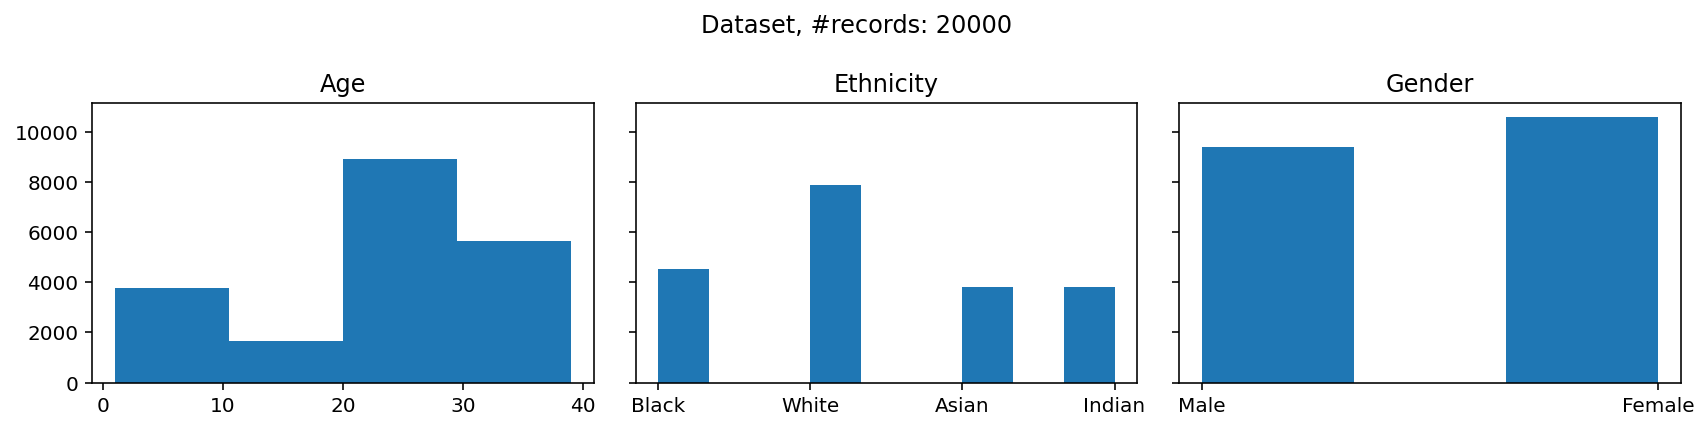

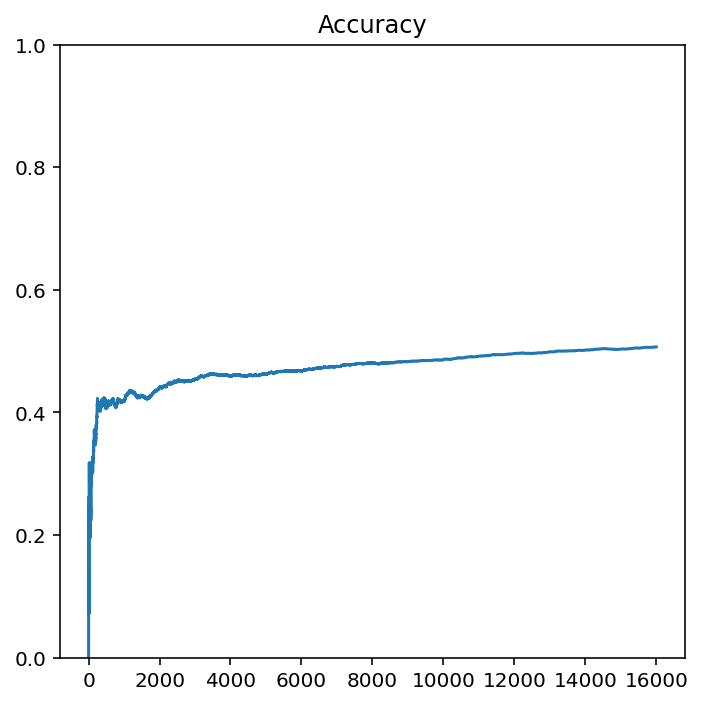

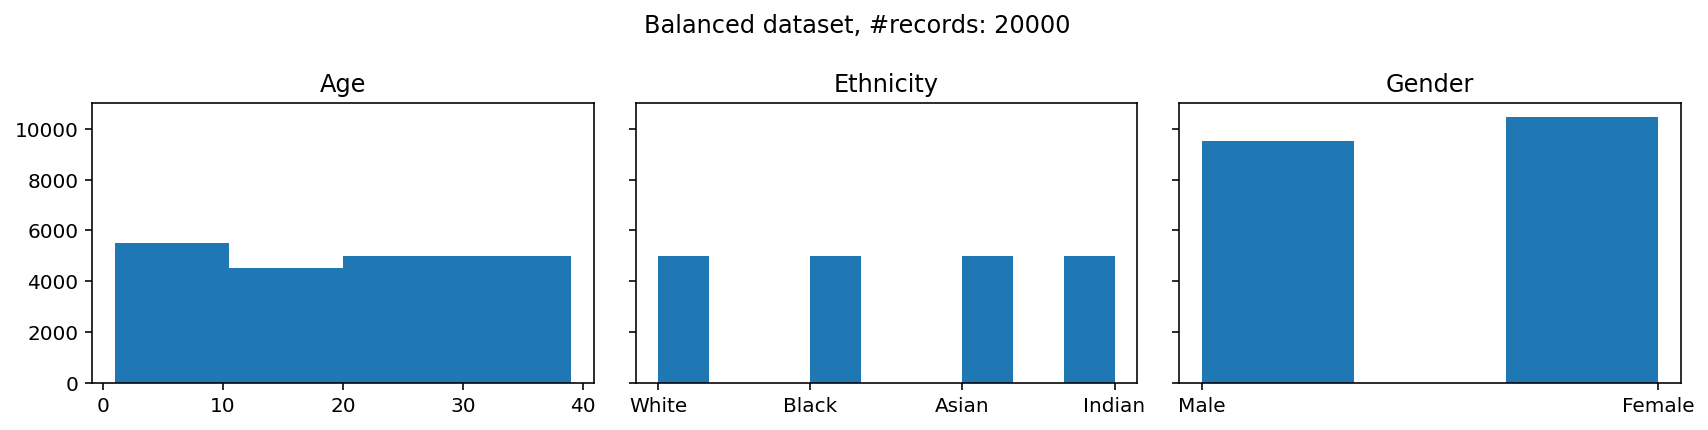

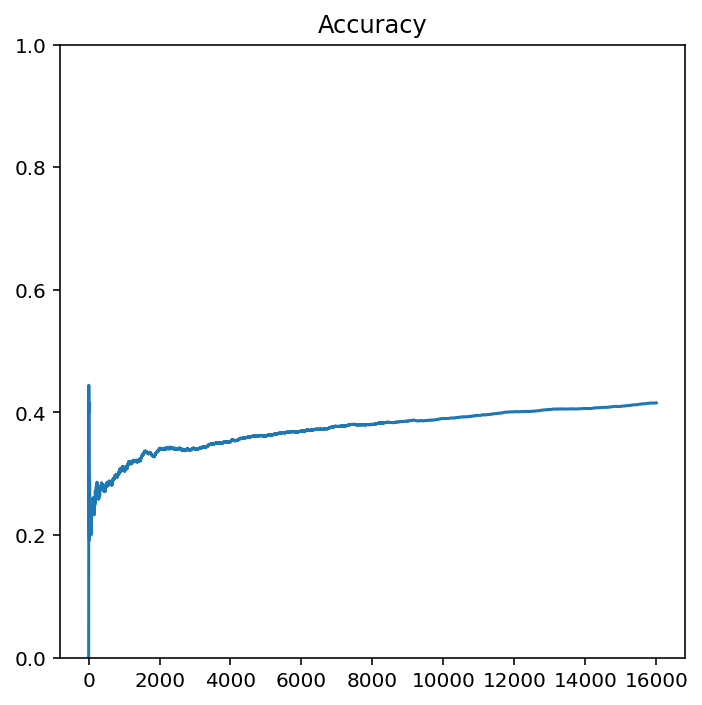

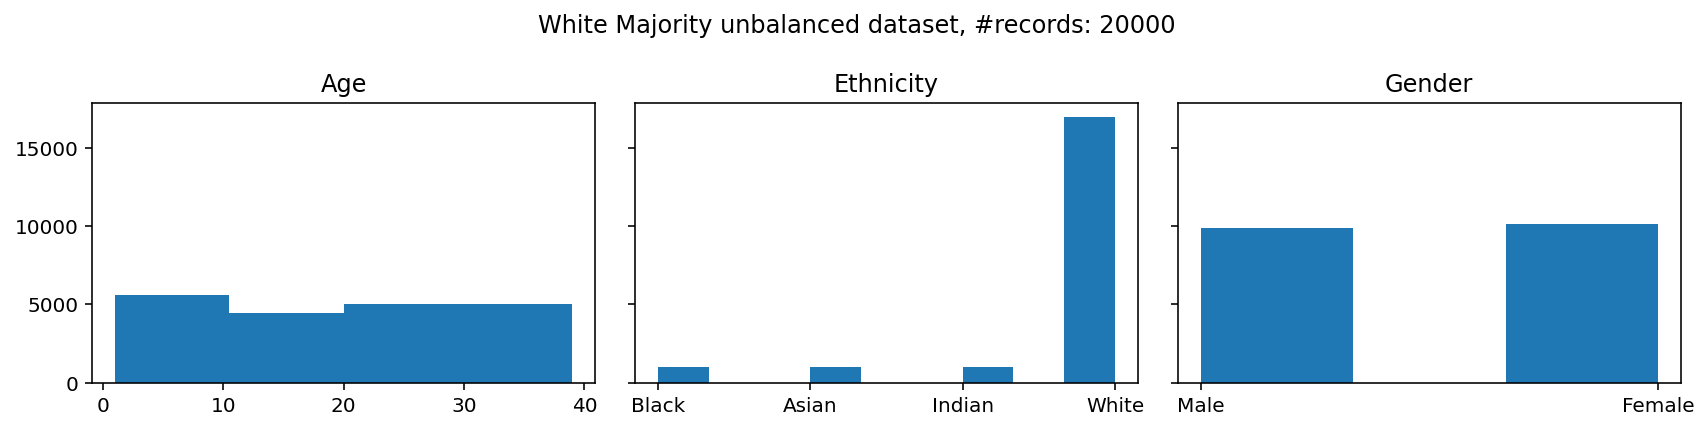

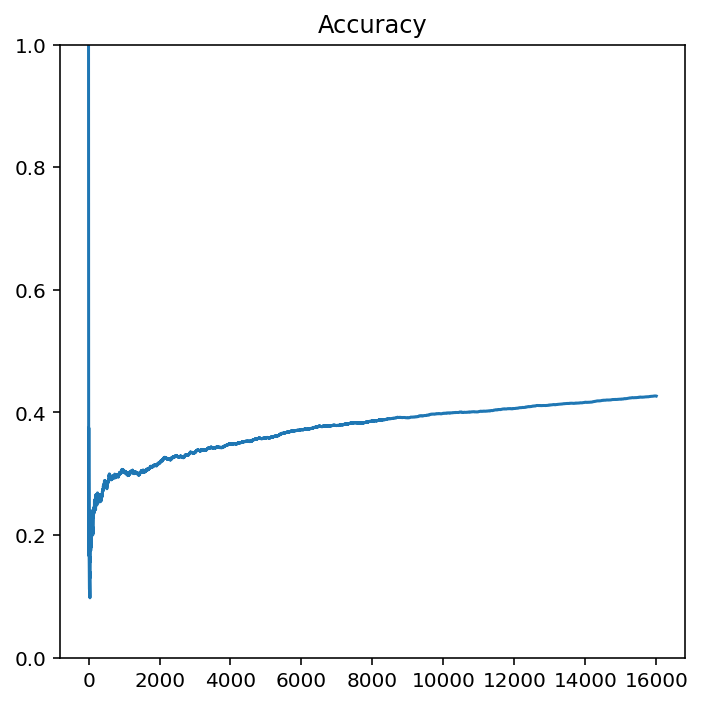

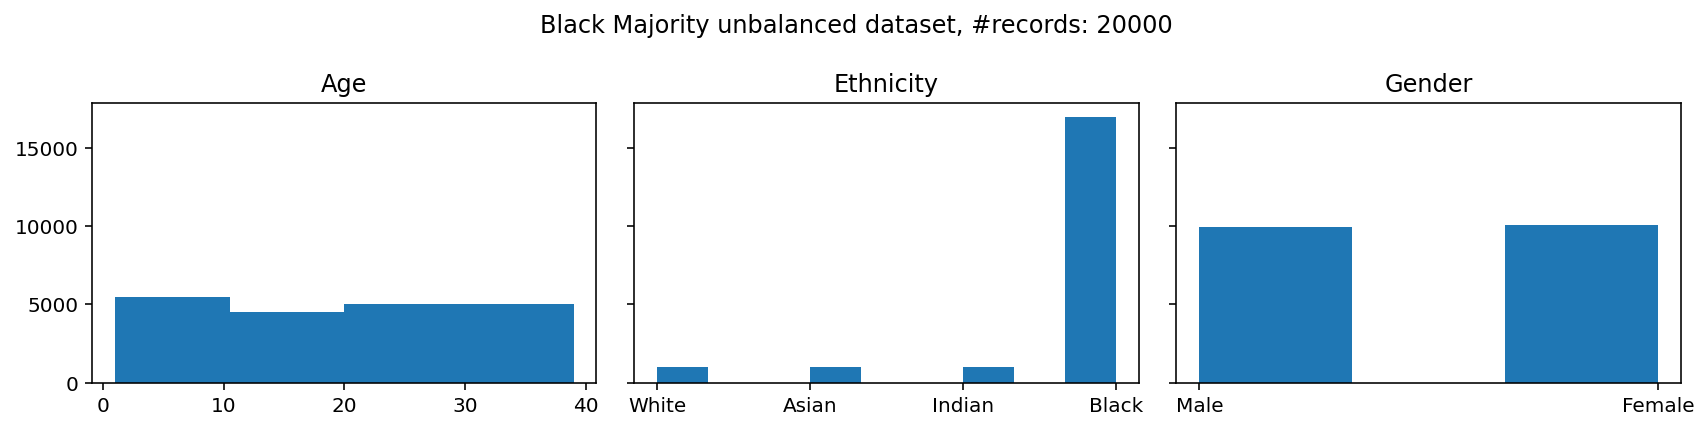

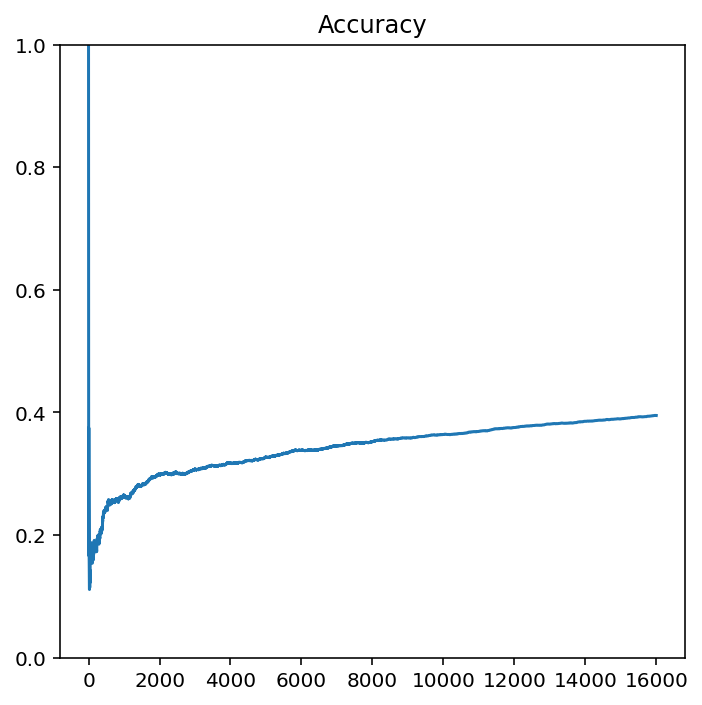

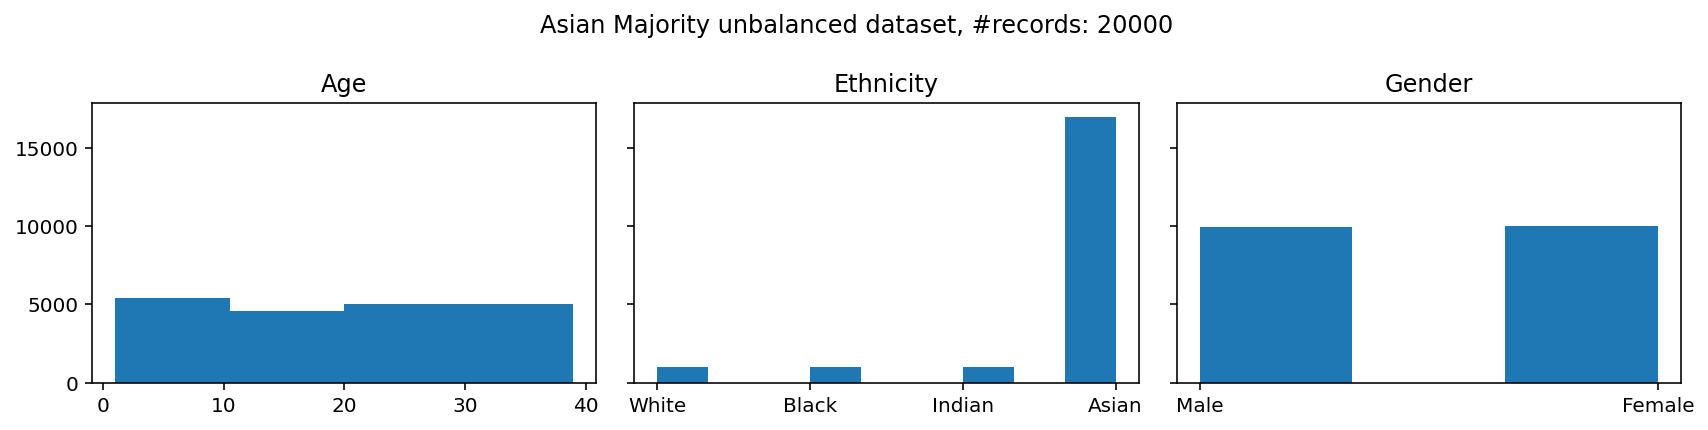

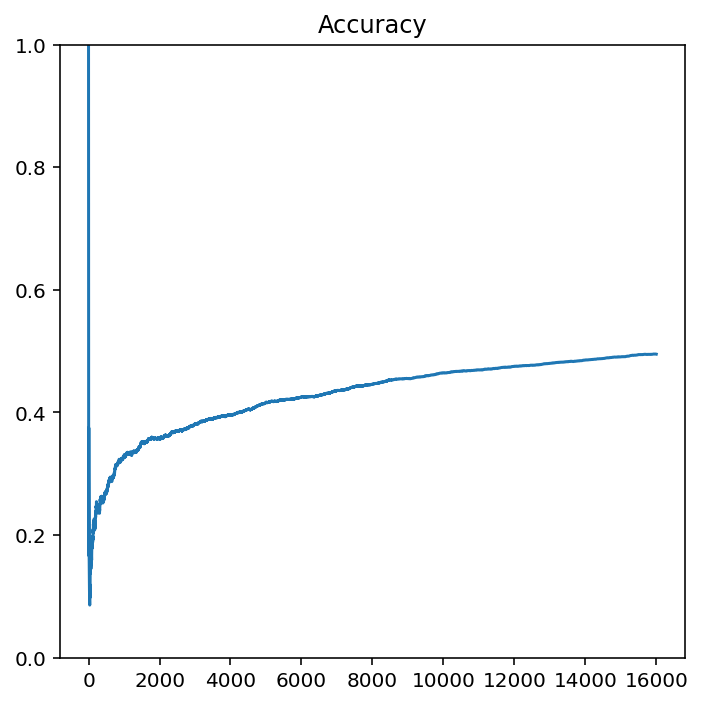

In [ ]:
dfs = [
    df.sample(p['data_samples'], random_state=p['seed'], replace=True), #Sample of the actual set
    balanced_df                                                         #Artificial Balanced set
] + [
    create_unbalanced_set(df, 1 - p['privileged_group_proportion'], i)  #All minority groups set
    for i in p['ETHNICITIES'].keys()
]

models = []
for i in range(len(dfs)):
    models += [standard_nn()] 

exp_ids = ['Dataset', 'Balanced dataset'] + [
    p['ETHNICITIES'][i] + ' Majority unbalanced dataset'
    for i in p['ETHNICITIES'].keys()
]

metrics = compare_model_behaviour(
    dfs, 
    models,
    exp_ids
)

In [ ]:
%%notify

def get_metrics_data(metrics):
    metrics_df = pd.DataFrame()
    for m in metrics:
        row = pd.Series(m)
        metrics_df = metrics_df.append(row, ignore_index=True)
    return metrics_df

In [ ]:
print(f'Epochs: {p["epochs_n"]}, lr: {p["learning_rate"]}, privileged proportion: {p["privileged_group_proportion"]}%')
get_metrics_data(metrics)

In [ ]:
def get_perc_increment(row_before, row_after):
    perc_inc = (row_after - row_before) / np.abs(row_before) * 100
    return perc_inc
    
considered_metrics = ['accuracy', 
            'accuracy variance', 
            'f1', 'f1 variance', 
           'Abs avg. Statistical parity difference',
            'Abs avg. Equal opportunity difference',
            'Abs avg. Equal odd difference'
           ]

metrics_df = pd.DataFrame(metrics)

inc_df = pd.DataFrame([
    get_perc_increment(
        metrics_df.iloc[1][considered_metrics].values, 
        metrics_df.iloc[i][considered_metrics].values
    ) for i in range(2, len(metrics))
], columns=considered_metrics)

print('Means')
display(metrics_df[considered_metrics].mean())

print('Increment table from balance to imbalance')
display(inc_df)

print('Mean of increments')
display(inc_df.mean())

### Human evaluation & plots

In [ ]:
s_size = 10
s_bal_df = balanced_df.reset_index().sample(s_size).reset_index()
for idx in range(len(s_bal_df)):
    predict_row(s_bal_df, idx, models[1])